# Load raw data

In [361]:
import numpy as np

In [407]:
data = np.loadtxt('SlowSteps1.csv', delimiter = ',') # load the raw data, change the filename as required!

# Find spikes

In [408]:
time_s = (data[:,8]-data[0,8])/1000000 # set the timing array to seconds and subtract 1st entry to zero it
n_spikes = 0
spike_times = [] # in seconds
spike_points = [] # in timepoints
for x in range(1, data.shape[0]-1):
    if (data[x,0]>10 and data[x-1,0]<10): # looks for all instances where subsequent Vm points jump from <10 to >10
        spike_times.append(time_s[x])
        spike_points.append(x)
        n_spikes+=1
    
print(n_spikes, "spikes detected") 


168 spikes detected


# Compute spike rate

In [394]:
spike_rate = np.zeros(data.shape[0])

for x in range(0, n_spikes-1):
    current_rate = 1/(spike_times[x+1]-spike_times[x])
    spike_rate[spike_points[x]:spike_points[x+1]]=current_rate


# Plot raw data and spike rate

In [395]:
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import column
from bokeh.models import Range1d

output_file("RawDataPlot.html")

spike_plot = figure(plot_width=1200, plot_height = 100)
spike_plot.line(time_s[:],spike_rate[:], line_width=1, line_color="black") # Spike rate
spike_plot.yaxis[0].axis_label = 'Rate (Hz)'
spike_plot.xgrid.grid_line_color =None
spike_plot.ygrid.grid_line_color =None
spike_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
spike_plot.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

vm_plot = figure(plot_width=1200, plot_height = 300, y_range=Range1d(-100, 50),x_range=spike_plot.x_range)
vm_plot.line(time_s[:],data[:,0], line_width=1, line_color="black") # Vm
vm_plot.scatter(spike_times[:],45, line_color="black") # Rasterplot over spikes
vm_plot.yaxis[0].axis_label = 'Vm (mV)'
vm_plot.xgrid.grid_line_color =None
vm_plot.ygrid.grid_line_color =None
vm_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels

itotal_plot = figure(plot_width=1200, plot_height = 200, x_range=spike_plot.x_range)
itotal_plot.line(time_s[:], data[:,1], line_width=1, line_color="black") # Itotal
itotal_plot.yaxis[0].axis_label = 'I total (a.u.)'
itotal_plot.xgrid.grid_line_color =None
itotal_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels

in_spikes_plot = figure(plot_width=1200, plot_height = 80, y_range=Range1d(-0.1,1.1), x_range=spike_plot.x_range)
in_spikes_plot.line(time_s[:], data[:,3], line_width=1, line_color="black") # Spikes in from Port 1
in_spikes_plot.line(time_s[:], data[:,4], line_width=1, line_color="grey") # Spikes in from Port 2
in_spikes_plot.yaxis[0].axis_label = 'Input spikes'
in_spikes_plot.xgrid.grid_line_color =None
in_spikes_plot.ygrid.grid_line_color =None
in_spikes_plot.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
in_spikes_plot.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
in_spikes_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
in_spikes_plot.yaxis.major_label_text_font_size = '0pt'  # turn off y-axis tick labels

stim_plot = figure(plot_width=1200, plot_height = 100,y_range=Range1d(-0.1,1.1), x_range=spike_plot.x_range)
stim_plot.line(time_s[:], data[:,2], line_width=1, line_color="black") # Stimulus
stim_plot.yaxis[0].axis_label = 'Stimulus'
stim_plot.xaxis[0].axis_label = 'Time (s)'
stim_plot.xgrid.grid_line_color =None
stim_plot.ygrid.grid_line_color =None
stim_plot.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
stim_plot.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
stim_plot.yaxis.major_label_text_font_size = '0pt'  # turn off y-axis tick labels

show(column(spike_plot,vm_plot,itotal_plot,in_spikes_plot,stim_plot))


# Analysis Option 1: Trigger stimuli and align

In [377]:
stimulus_times = []
stimulus_times_s = []
for x in range(0, data.shape[0]-1): # goes through each timepoint
    if (data[x,2]<data[x+1,2]): # checks if the stimulus went from 0 to 1
        stimulus_times.append(x) ## make a list of times (in points) when stimulus increased     
        stimulus_times_s.append(time_s[x]) ## also make a list of times (in seconds)
        
loop_duration = stimulus_times[1]-stimulus_times[0] # compute arraylength for single stimulus
loop_duration_s = stimulus_times_s[1]-stimulus_times_s[0] # compute arraylength for single stimulus also in s

print(loop_duration, "points per loop;", loop_duration_s, "seconds")

sr_loops = []
vm_loops = []
itotal_loops = []
stim_loops = []

stimulus_times = np.where(data[:,2]>np.roll(data[:,2], axis = 0, shift = 1)) ## make a list of times when stimulus increased (again)
sr_loops = np.vstack([spike_rate[x:x+loop_duration] for x in stimulus_times[0][:-1]])
vm_loops = np.vstack([data[x:x+loop_duration, 0] for x in stimulus_times[0][:-1]])
itotal_loops = np.vstack([data[x:x+loop_duration, 1] for x in stimulus_times[0][:-1]])
stim_loops = np.vstack([data[x:x+loop_duration, 2] for x in stimulus_times[0][:-1]])

st_loops = []
for i, x in enumerate(stimulus_times[0][:-1]):
    st_loops.append([time_s[sp]-time_s[x] for sp in spike_points if sp > x and sp < x+loop_duration])

loops = vm_loops.shape[0]
print(loops, "loops")  



4000 points per loop; 7.27066 seconds
8 loops


# Make average arrays


In [371]:
sr_mean = np.mean(sr_loops, axis=0)
vm_mean = np.mean(vm_loops, axis=0)
itotal_mean = np.mean(itotal_loops, axis=0)
stim_mean = np.mean(stim_loops, axis=0)

# Plot stimulus aligned data

In [381]:
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import column
from bokeh.models import Range1d

output_file("AlignedDataPlot.html")

spike_plot = figure(plot_width=400, plot_height = 100)
for i in range(0,loops-1):
    spike_plot.line(time_s[0:loop_duration],sr_loops[i,:], line_width=1, line_color="gray") # Vm individual repeats
spike_plot.line(time_s[0:loop_duration],sr_mean[:], line_width=1.5, line_color="black") # Vm mean
spike_plot.yaxis[0].axis_label = 'Rate (Hz)'
spike_plot.xgrid.grid_line_color =None
spike_plot.ygrid.grid_line_color =None
spike_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels


dot_plot = figure(plot_width=400, plot_height = 100, x_range=spike_plot.x_range)
for i in range(0,loops-1):
   dot_plot.scatter(st_loops[i],i, line_color="black") # Rasterplot
dot_plot.yaxis[0].axis_label = 'Repeat'
dot_plot.xgrid.grid_line_color =None
dot_plot.ygrid.grid_line_color =None
dot_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels


vm_plot = figure(plot_width=400, plot_height = 300, y_range=Range1d(-100, 40),x_range=spike_plot.x_range)
for i in range(0,loops-1):
    vm_plot.line(time_s[0:loop_duration],vm_loops[i,:], line_width=1, line_color="gray") # Vm individual repeats
vm_plot.line(time_s[0:loop_duration],vm_mean[:], line_width=1.5, line_color="black") # Vm mean
vm_plot.yaxis[0].axis_label = 'Vm (mV)'
vm_plot.xgrid.grid_line_color =None
vm_plot.ygrid.grid_line_color =None
vm_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels

itotal_plot = figure(plot_width=400, plot_height = 200, x_range=spike_plot.x_range)
for i in range(0,loops-1):
    itotal_plot.line(time_s[0:loop_duration], itotal_loops[i,:], line_width=1, line_color="gray") # Itotal individual repeats
itotal_plot.line(time_s[0:loop_duration], itotal_mean[:], line_width=1.5, line_color="black") # Itotal mean
itotal_plot.yaxis[0].axis_label = 'Itotal (a.u.)'
itotal_plot.xgrid.grid_line_color =None
itotal_plot.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels

stim_plot = figure(plot_width=400, plot_height = 100,y_range=Range1d(-0.1,1.1), x_range=spike_plot.x_range)
for i in range(0,loops-1):
    stim_plot.line(time_s[0:loop_duration], stim_loops[i,:], line_width=1, line_color="gray") # Stimulus individual repeats
stim_plot.line(time_s[0:loop_duration], stim_mean[:], line_width=1.5, line_color="black") # Stimulus mean   
stim_plot.yaxis[0].axis_label = 'Stimulus'
stim_plot.xaxis[0].axis_label = 'Time (s)'
stim_plot.xgrid.grid_line_color =None
stim_plot.ygrid.grid_line_color =None
stim_plot.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
stim_plot.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
stim_plot.yaxis.major_label_text_font_size = '0pt'  # turn off y-axis tick labels

show(column(spike_plot,dot_plot,vm_plot,itotal_plot,stim_plot))

# Analysis option 2: Spike triggered average (STA)

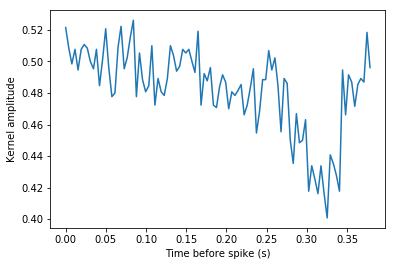

In [403]:
sta_points = 200 # number of points computed

sta_individual = []
sta_individual = np.vstack([data[x-sta_points:x,2] for x in spike_points[2:-1]])
sta = np.mean(sta_individual, axis=0)

import matplotlib.pyplot as plt
plt.plot(time_s[0:200],sta[:])
plt.ylabel('Kernel amplitude')
plt.xlabel('Time before spike (s)')
plt.show()

